In [1]:
!pip install lightgbm==3.1.1

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 5.8 MB/s eta 0:00:00
  Attempting uninstall: lightgbm
    Found existing installation: lightgbm 4.1.0
    Uninstalling lightgbm-4.1.0:
      Successfully uninstalled lightgbm-4.1.0


In [11]:
#@title Load station and meteorological model. Save fusion file

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import time
import seaborn as sns
import pickle


def transform_value_l(val):
    first_decimal = int(str(val)[2]) if len(str(val)) > 2 else 0
    return f'CL{first_decimal}'

def transform_value_m(val):
    first_decimal = int(str(val)[2]) if len(str(val)) > 2 else 0
    return f'CM{first_decimal}'

def transform_to_nearest_odd(arr):
    # Make a copy of the input array
    arr_copy = arr.copy()

    # Find even numbers
    even_indices = arr_copy % 2 == 0

    # Increment even numbers to the nearest odd number
    arr_copy[even_indices] += 1

    return arr_copy.astype(str)

def custom_round(value):
    if value > 9001:
        return str(9999)
    elif value < 1000:
        return str(500)
    else:
        return str(round(value / 1000) * 1000)



pd.options.display.max_rows = 999

station_raw = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/airport_ml/LECO/input_files/LECOY2018Y2022.csv",
                          parse_dates=["time"]).dropna().set_index("time")

#Load
mody2018 = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/airport_ml/LECO/input_files/lat43.302lon-8.377p4R4KmD0Y2018.csv",parse_dates=["time"])
mody2019 = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/airport_ml/LECO/input_files/lat43.302lon-8.377p4R4KmD0Y2019.csv",parse_dates=["time"])
mody2020 = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/airport_ml/LECO/input_files/lat43.302lon-8.377p4R4KmD0Y2020.csv",parse_dates=["time"])
mody2021 = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/airport_ml/LECO/input_files/lat43.302lon-8.377p4R4KmD0Y2021.csv",parse_dates=["time"])
mody2022 = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/airport_ml/LECO/input_files/lat43.302lon-8.377p4R4KmD0Y2022.csv",parse_dates=["time"])
df_all = pd.concat([mody2018,mody2019,mody2020,mody2021,mody2022]).drop(columns=["Unnamed: 0"]).set_index("time")

#add time variables
df_all["hour"] = df_all.index.hour
df_all["month"] = df_all.index.month
df_all["dayofyear"] = df_all.index.dayofyear
df_all["weekofyear"] = df_all.index.isocalendar().week.astype(int)

#algorithms directory
algo_dir = "/content/drive/MyDrive/Colab Notebooks/airport_ml/LECO/algorithms/"

#wind direction to words
df_all["dir0_l"] = result = ["0" + c if len(c) == 2 else ("00" + c if len(c) == 1 else c) for c in (round(df_all["dir0"],-1).astype(int).astype(str))]
all = round(df_all["mod0"] * 1.94384, 0).astype(int).values
list_mod0 = ["0" + str(c) if len(c) == 1 else str(c) for c in transform_to_nearest_odd(all)]
df_all["wind"]=df_all["dir0_l"]+list_mod0+"kt"

#visibility words
"""
interval = pd.IntervalIndex.from_tuples([(-1.5, 20000),(20000,30000)])
labels = ['vi20d', 'vi20u']
df_all["visibility0_l"] = pd.cut(df_all["visibility0"], bins=interval,retbins=False,
                        labels=labels).map({a:b for a,b in zip(interval,labels)}).astype("str")
df_all[["visibility0_l","visibility0"]].sample(100)

# Define the old and new min and max values
old_min = 26.731182
old_max = 24235.0
new_min = 50
new_max = 9999

# Calculate the scale (a) and shift (b) factors
a = (new_max - new_min) / (old_max - old_min)
b = new_min - a * old_min

df_all['visibility0_l'] = ((a * df_all['visibility0'] + b).round().astype(int)).apply(custom_round)
"""
alg = pickle.load(open(algo_dir+"llmvis_LECO_d0.al","rb"))
model_x_var = df_all[alg["x_var"]]
df_all["vis_ml"] =  alg["pipe"].predict(model_x_var)


#rh in words
interval = pd.IntervalIndex.from_tuples([(-1.5, .80),(.80,100)])
labels = ['rhd80', 'rhu80']
df_all["rh0_l"] = pd.cut(df_all["rh0"], bins=interval,retbins=False,
                        labels=labels).map({a:b for a,b in zip(interval,labels)}).astype("str")
df_all[["rh0_l","rh0"]].sample(100)


#wx words
alg = pickle.load(open(algo_dir+"llmwx_LECO_d0.al","rb"))
model_x_var = df_all[alg["x_var"]]
df_all["wx_ml"] =  alg["pipe"].predict(model_x_var)

"""
alg = pickle.load(open(algo_dir+"llmprec_LECO_d0.al","rb"))
model_x_var = df_all[alg["x_var"]]
df_all["prec_ml"] =  alg["pipe"].predict(model_x_var)

interval = pd.IntervalIndex.from_tuples([(-1.5, 0.1),(.1,180)])
labels = ['prec0n', 'prec0y']
df_all["prec0_l"] = pd.cut(df_all["prec0"], bins=interval,retbins=False,
                        labels=labels).map({a:b for a,b in zip(interval,labels)}).astype("str")
df_all[["prec0_l","prec0"]].sample(100)
"""

#cfl words
#df_all['cfl0_l'] = round(df_all["cfl0"],1).apply(transform_value_l)
alg = pickle.load(open(algo_dir+"llmskyc1_LECO_d0.al","rb"))
model_x_var = df_all[alg["x_var"]]
df_all["cfl_ml"] =  alg["pipe"].predict(model_x_var)

#clouds height
alg = pickle.load(open(algo_dir+"llmskyl1_LECO_d0.al","rb"))
model_x_var = df_all[alg["x_var"]]
df_all["cfll1_ml"] =  alg["pipe"].predict(model_x_var)


#cfm words
#df_all['cfm0_l'] = round(df_all["cfm0"],1).apply(transform_value_m)
alg = pickle.load(open(algo_dir+"llmskyc2_LECO_d0.al","rb"))
model_x_var = df_all[alg["x_var"]]
df_all["cfm_ml"] =  alg["pipe"].predict(model_x_var)

#temp words
alg = pickle.load(open(algo_dir+"temp_LECO_d0.al","rb"))
model_x_var = df_all[alg["x_var"]]
df_all["temp"] =  alg["pipe"].predict(model_x_var)
df_all["temp_ml"] = ["0" + c if len(c) == 1 else c for c in round(df_all["temp"]-273.16,0).astype(int).astype(str)]
df_all["temp0_l"] = ["0" + c if len(c) == 1 else c for c in round(df_all["temp0"]-273.16,0).astype(int).astype(str)]

#temp dew words
alg = pickle.load(open(algo_dir+"llmtempd_LECO_d0.al","rb"))
model_x_var = df_all[alg["x_var"]]
df_all["tempd"] =  alg["pipe"].predict(model_x_var)
df_all["tempd_ml"] = ["0" + c if len(c) == 1 else c for c in round(df_all["tempd"]-273.16,0).astype(int).astype(str)]


#mslp words
alg = pickle.load(open(algo_dir+"pres_LECO_d0.al","rb"))
model_x_var = df_all[alg["x_var"]]
df_all["pres"] =  alg["pipe"].predict(model_x_var)
pres = round(df_all["pres"],0).astype(int).astype(str)
df_all["mslp_ml"] =[ "q"+p if len(p)==4 else "q0"+p for p in pres]

#time variables
df_all['hour'] = 'H' + df_all.index.hour.astype(str)
df_all['month'] = 'M' + df_all.index.month.astype(str)

#select variable met model
df_all["model_seed"]= df_all["wind"]+" "+df_all["vis_ml"]+" "+df_all["wx_ml"]+" "+df_all["cfl_ml"]+df_all["cfll1_ml"]+" "+df_all["cfm_ml"]+" "+df_all["temp_ml"]+ " "+df_all["tempd_ml"]+" "+df_all["mslp_ml"]


station_raw["metar_o"] = station_raw["metar_o"].astype(str)
station_raw["metar_o"] = station_raw["metar_o"].str.split().apply(lambda x: ' '.join(x[2:]) if len(x) > 2 else '')
station_clean_auto = [station_raw["metar_o"][i].replace("AUTO"+ " ", "") for i in range(0,len(station_raw["metar_o"]))]
station_raw["metar_o"] =station_clean_auto

result = pd.concat([station_raw,df_all["model_seed"]],axis=1).dropna()
result["fusion"]= result["model_seed"]+" "+result["metar_o"]

#save fusion
#path_result = "/content/drive/MyDrive/Colab Notebooks/gpt/i+d/fusionml.csv"
path_result = "/content/drive/MyDrive/Colab Notebooks/airport_ml/LECO/notebooks/LECOfusionml.csv"
result["fusion"].to_csv(path_result)
result["fusion"].sample(100).values

array(['31001kt 9999 WM OVC010 M 12 10 q1017 VRB01KT 8000 OVC008 11/11 Q1017',
       '16005kt 9999 WM MNClD M 22 17 q1013 16004KT 110V220 CAVOK 24/18 Q1012 NOSIG',
       '17007kt 9999 WM MNClD M 11 10 q1022 14003KT 120V190 CAVOK 12/10 Q1022 NOSIG',
       '35005kt 9999 WM SCT025 BKN 18 15 q1021 VRB02KT 9999 FEW024 BKN031 19/14 Q1020 NOSIG',
       '21005kt 9999 WM OVC040 M 05 05 q1034 19003KT 9999 OVC035 06/05 Q1034 NOSIG',
       '19007kt 9999 WM FEW030 M 08 07 q1010 13006KT 9999 FEW030 08/07 Q1009 NOSIG',
       '34003kt 9999 WM FEW030 M 10 07 q0996 VRB02KT 9999 FEW027 BKN033 09/07 Q0995 TEMPO SHRA SCT030TCU',
       '31003kt 9999 WM FEW030 M 08 06 q1024 19005KT 9999 BCFG FEW022 07/07 Q1024 NOSIG',
       '34011kt 9999 WM BKN025 M 20 14 q1024 36009KT 320V060 9999 BKN023 19/15 Q1023 NOSIG',
       '22019kt 9999 WM SCT040 M 15 12 q1009 22015G33KT 200V270 9999 SCT040 16/11 Q1010 NOSIG',
       '28009kt 9999 RA FEW040 M 16 10 q1017 22012KT 7000 SHRA FEW025 FEW040CB 15/11 Q1016 TEMPO 30

In [5]:
#@title Pressure
df_p = pd.concat([df_all[["mslp0","pres"]].astype(int),station_raw["mslp_o"].astype(int)],axis=1).dropna()
df_p["dif_metmodel"]=df_p["mslp0"]/100-df_p["mslp_o"]
df_p["dif_ml"]=df_p["pres"]-df_p["mslp_o"]
df_p.describe()



,mslp0,pres,mslp_o,dif_metmodel,dif_ml
count,40769.000000,40769.000000,40769.000000,40769.000000,40769.000000
mean,101796.467733,1017.324168,1017.825529,0.139148,-0.501361
std,760.119289,7.347982,7.379165,0.807882,0.648407
min,96874.000000,976.000000,975.000000,-12.260000,-13.000000
25%,101408.000000,1014.000000,1014.000000,-0.350000,-1.000000
50%,101844.000000,1018.000000,1018.000000,0.140000,-1.000000
75%,102257.000000,1022.000000,1022.000000,0.630000,0.000000
max,103878.000000,1036.000000,1038.000000,5.690000,5.000000


In [6]:
#@title Temperature

df_t = pd.concat([df_all[["temp0_l","temp_ml"]].astype(int),round(station_raw["temp_o"]-273.16,0).astype(int)],axis=1).dropna()
df_t["dif_metmodel"]=df_t["temp0_l"]-df_t["temp_o"]
df_t["dif_ml"]=df_t["temp_ml"]-df_t["temp_o"]
df_t.describe()

,temp0_l,temp_ml,temp_o,dif_metmodel,dif_ml
count,40769.000000,40769.000000,40769.000000,40769.000000,40769.000000
mean,14.361844,14.283745,14.442910,-0.081066,-0.159165
std,5.154349,5.050140,5.193785,1.972393,1.105105
min,0.000000,-2.000000,-3.000000,-9.000000,-6.000000
25%,11.000000,11.000000,11.000000,-1.000000,-1.000000
50%,14.000000,14.000000,14.000000,0.000000,0.000000
75%,17.000000,18.000000,18.000000,1.000000,0.000000
max,37.000000,32.000000,36.000000,11.000000,6.000000


In [7]:
#@title dew Temperature

df_tw = pd.concat([df_all["tempd_ml"].astype(int),round(station_raw["tempd_o"]-273.16,0).astype(int)],axis=1).dropna()

df_tw["dif_ml"]=df_tw["tempd_ml"]-df_tw["tempd_o"]
df_tw.describe()

,tempd_ml,tempd_o,dif_ml
count,40769.000000,40769.000000,40769.000000
mean,10.842380,11.002502,-0.160122
std,4.343772,4.487685,1.074089
min,-3.000000,-4.000000,-5.000000
25%,8.000000,8.000000,-1.000000
50%,11.000000,11.000000,0.000000
75%,14.000000,15.000000,0.000000
max,21.000000,23.000000,7.000000


,cfh0,cfl0,cfm0,visibility_o
cfh0,1.000000,0.207820,0.323252,-0.024380
cfl0,0.207820,1.000000,0.684355,-0.239093
cfm0,0.323252,0.684355,1.000000,-0.228608
visibility_o,-0.024380,-0.239093,-0.228608,1.000000


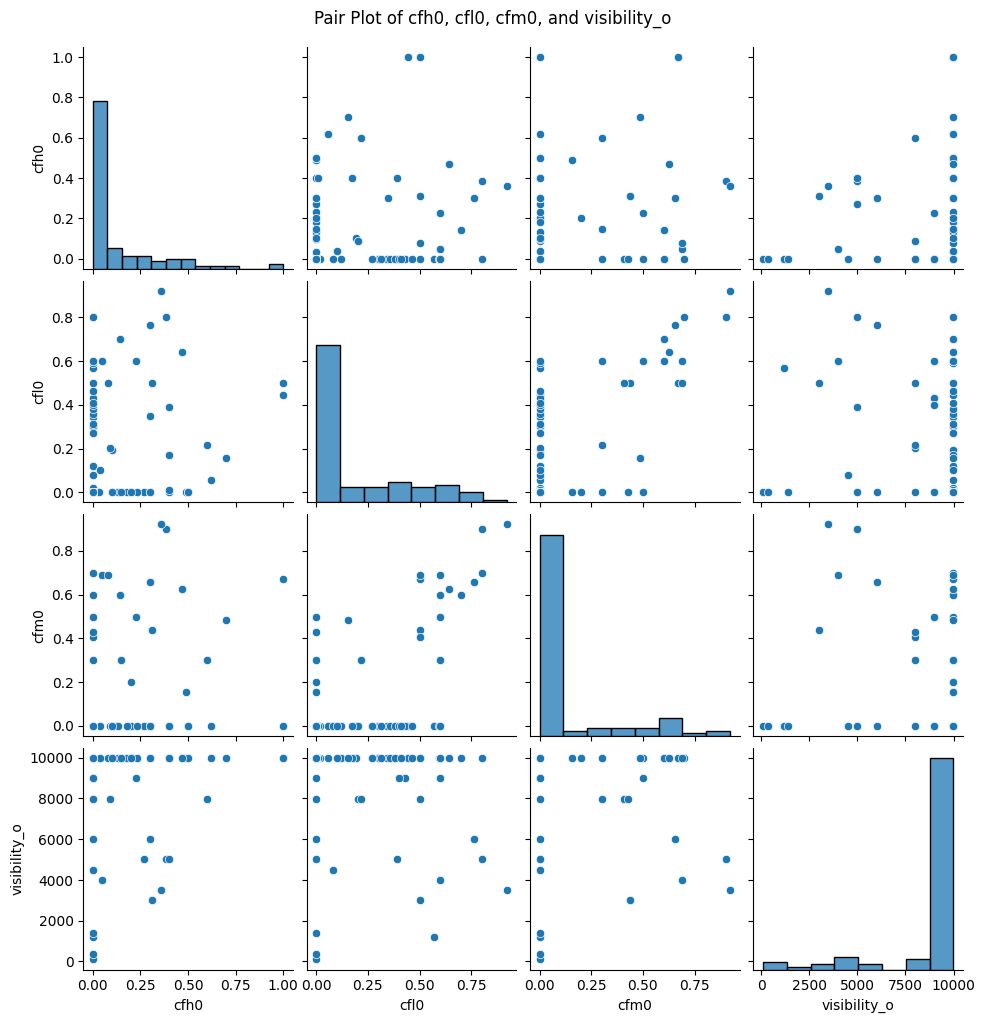

In [8]:
#@title Clouds
df_clo = pd.concat([df_all[['cfh0', 'cfl0', 'cfm0']],station_raw['visibility_o']],axis=1).dropna().sample(100)
display(df_clo.corr())
sns.pairplot(df_clo)
plt.suptitle('Pair Plot of cfh0, cfl0, cfm0, and visibility_o', y=1.02)
plt.show()


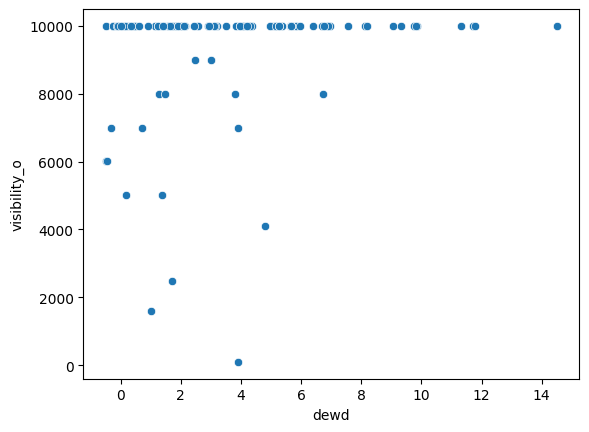

In [9]:
#@title Temperature minus temperature dew point
#dew_temperature = dry_temperature - (100 - relative_humidity) / 5
df_all["dewd"] = df_all["temp0"]-round(df_all["temp0"]- (100 - df_all["rh0"]*100) / 5,0)
vis = pd.concat([df_all["dewd"],station_raw["visibility_o"]],axis=1).dropna()
vis.describe()
sns.scatterplot(vis.sample(100),x="dewd",y="visibility_o");

In [10]:
vis.describe()

,dewd,visibility_o
count,40769.000000,40769.000000
mean,3.589733,9295.864456
std,2.877702,2036.840841
min,-0.499878,48.000000
25%,1.215698,9994.000000
50%,3.076111,9994.000000
75%,5.504486,9994.000000
max,14.500488,9994.000000
